In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from itertools import product

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools


import utils
import discrete_obs 
import plot

import data_collections

In [3]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

Client Scheduler: tcp://10.12.206.51:38293 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


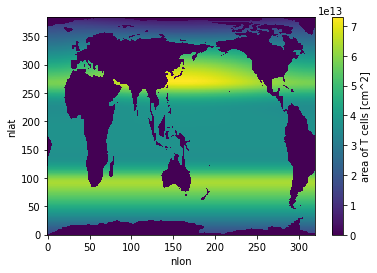

In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
masked_area = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.).expand_dims('region')
masked_area.plot()

In [5]:
nmolcm3_to_µM = 1.

varlist = [
    'DOC',
    'DOCr',
    'DOCt',
    'DON',
    'DONr',
    'DONt',
    'DOP',
    'DOPr',
    'DOPt',    
]

coll = data_collections.epoch_mean(
    query=dict(experiment='historical', stream='pop.h'),
)
dsets = coll.to_dataset_dict(varlist, clobber=False)
_, ds = dsets.popitem()

with xr.set_options(keep_attrs=True):
    ds = ds.mean('member_id')

for v in varlist:
    if ds[v].attrs['units'] == 'mmol/m^3':
        ds[v].attrs['units'] = 'µM'

dsp = utils.pop_add_cyclic(ds)
dsp.info()   

xarray.Dataset {
dimensions:
	lat_aux_grid = 395 ;
	moc_z = 61 ;
	nlat = 384 ;
	nlon = 321 ;
	z_t = 60 ;
	z_t_150m = 15 ;
	z_w = 60 ;
	z_w_bot = 60 ;
	z_w_top = 60 ;

variables:
	float32 z_t(z_t) ;
		z_t:long_name = depth from surface to midpoint of layer ;
		z_t:units = centimeters ;
		z_t:positive = down ;
		z_t:valid_min = 500.0 ;
		z_t:valid_max = 537500.0 ;
	float64 TLAT(nlat, nlon) ;
	float64 TLONG(nlat, nlon) ;
	float64 DOC(z_t, nlat, nlon) ;
		DOC:long_name = Dissolved Organic Carbon ;
		DOC:units = µM ;
		DOC:grid_loc = 3111 ;
		DOC:cell_methods = time: mean ;
	float64 HTE(nlat, nlon) ;
		HTE:long_name = cell widths on East sides of T cell ;
		HTE:units = centimeters ;
	float64 DXT(nlat, nlon) ;
		DXT:long_name = x-spacing centered at T points ;
		DXT:units = centimeters ;
	float64 T0_Kelvin() ;
		T0_Kelvin:long_name = Zero Point for Celsius ;
		T0_Kelvin:units = degK ;
	float64 salt_to_ppt() ;
		salt_to_ppt:long_name = Convert Salt in gram/gram to g/kg ;
	float64 heat_to_PW()

In [6]:
client.close()
cluster.close()
del client
del cluster

In [7]:
%%time

df = discrete_obs.open_datastream('DOM')
df = df.loc[df.month != 0]
for v in ['DONt', 'DOPt', 'DOCt']:
    df.obs_stream.add_model_field(ds[v], field_name=v)

df.obs_stream.add_model_field(ds_grid.REGION_MASK, method='nearest')
df

CPU times: user 31.3 s, sys: 130 ms, total: 31.4 s
Wall time: 31.5 s


,month,lon,lat,depth,DONt_obs,DOPt_obs,DOCt_obs,DONt,DOPt,DOCt,REGION_MASK
0,3,-49.30228,-35.08802,11.9,3.05,0.015,NaN,4.268617,0.157754,56.280749,1.0
1,3,-49.30228,-35.08802,28.3,5.14,0.132,NaN,4.265461,0.157699,56.246864,1.0
2,3,-49.30228,-35.08802,41.7,4.19,0.120,NaN,4.251975,0.157330,56.101877,1.0
3,3,-49.30228,-35.08802,45.1,4.79,0.118,NaN,4.246521,0.157168,56.043348,1.0
4,3,-49.30228,-35.08802,49.6,3.51,NaN,NaN,4.227620,0.156552,55.842015,1.0
...,...,...,...,...,...,...,...,...,...,...,...
73407,2,-71.70450,-32.50090,436.0,NaN,NaN,44.3825,0.812257,0.015592,15.307975,2.0
73408,2,-71.70450,-32.50090,484.3,NaN,NaN,NaN,0.803211,0.015143,15.239654,2.0
73409,2,-71.70450,-32.50090,565.7,NaN,NaN,54.9400,0.792619,0.014655,15.183139,2.0
73410,2,-71.70450,-32.50090,663.2,NaN,NaN,NaN,0.783126,0.014250,15.153217,2.0


In [8]:
mask3d = pop_tools.region_mask_3d('POP_gx1v7', mask_name='default')
mask3d.region

<xarray.DataArray 'region' (region: 13)>
array(['Black Sea', 'Baltic Sea', 'Red Sea', 'Southern Ocean', 'Pacific Ocean',
       'Indian Ocean', 'Persian Gulf', 'Atlantic Ocean', 'Mediterranean Sea',
       'Lab. Sea & Baffin Bay', 'GIN Seas', 'Arctic Ocean', 'Hudson Bay'],
      dtype='<U21')
Coordinates:
  * region   (region) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'

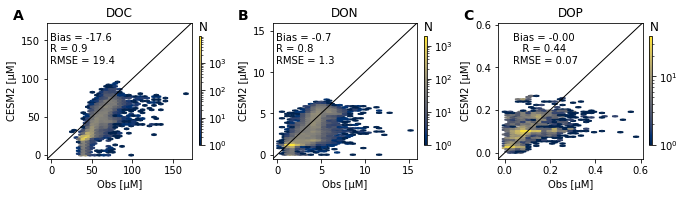

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


fig = plt.figure(figsize=(12, 2.5))
nrow, ncol = 1, 3 
gs = gridspec.GridSpec(
    nrows=10, ncols=ncol*3, 
    width_ratios=(1, 0.02, 0.4,)*ncol,
    wspace=0.1, 
    hspace=0.0,
)
axs = np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):    
    axs[i, j] = plt.subplot(gs[:, j*3])
    

depth_range = (0., 100000.)

for n, field in enumerate(['DOCt', 'DONt', 'DOPt']):
    ax = axs[0, n]
    
    df_sub = df.loc[(depth_range[0] <= df.depth) & (df.depth <= depth_range[1])]
    
    xobs, ymodel = df_sub[f'{field}_obs'], df_sub[field]
    k = np.isnan(xobs) | np.isnan(ymodel)
    xobs, ymodel = xobs[~k], ymodel[~k]
    bias = (ymodel - xobs).mean()
    xcorr = np.corrcoef(xobs, ymodel[~k])[0, 1]
    rmse = np.sqrt(np.sum((xobs - ymodel)**2)/len(xobs))
    
    sc = ax.hexbin(xobs, ymodel, #df_sub[f'{field}_obs'], df_sub[field], 
                   mincnt=1, gridsize=(25, 25), bins='log',
                   cmap='cividis',)
    
    
    #if n == 0:
    ax.set_ylabel('CESM2 [µM]')
    ax.set_xlabel('Obs [µM]')
    ax.set_title(field.replace('t', ''))
    xlm = ax.get_xlim()
    ylm = ax.get_ylim()
    
    xylm = (np.min([xlm[0], ylm[0]]), np.max((xlm[1], ylm[1])))
    ax.plot(xylm, xylm, 'k-', lw=1)
    ax.set_xlim(xylm)
    ax.set_ylim(xylm)

    if field in ['DOPt']:
        ax.text(
            xylm[0] + np.diff(xylm) * 0.1, xylm[1] - np.diff(xylm) * 0.3, 
            (f'Bias = {bias:0.2f}\n' +
             f'   R = {xcorr:0.2f}\n' +
             f'RMSE = {rmse:0.2f}'
            ),
            ha='left',            
        )
    else:
        ax.text(
            xylm[0] + np.diff(xylm) * 0.02, xylm[1] - np.diff(xylm) * 0.3, 
            (f'Bias = {bias:0.1f}\n' +
             f'R = {xcorr:0.1f}\n' +
             f'RMSE = {rmse:0.1f}'
            ),
            ha='left',
        )    
#     cax = inset_axes(ax, width="2%", height="45%", loc='lower left',
#                  bbox_to_anchor=(0.75, 0.05, 1, 1),
#                  bbox_transform=ax.transAxes,
#                 )    
    cax = plt.subplot(gs[1:-1, n*3+1])
    cb = plt.colorbar(sc, ax=ax, cax=cax)
    #cb.set_ticks(np.arange(310,  370, 10))
    cb.ax.set_title('N', loc='left') 
    #plt.plot([0, 5], [0, 5], 'r-')
    
utils.label_plots(fig, [ax for ax in axs.ravel()],)# xoff=0.02, yoff=0)       

utils.savefig('DOM-model-obs-scatter')

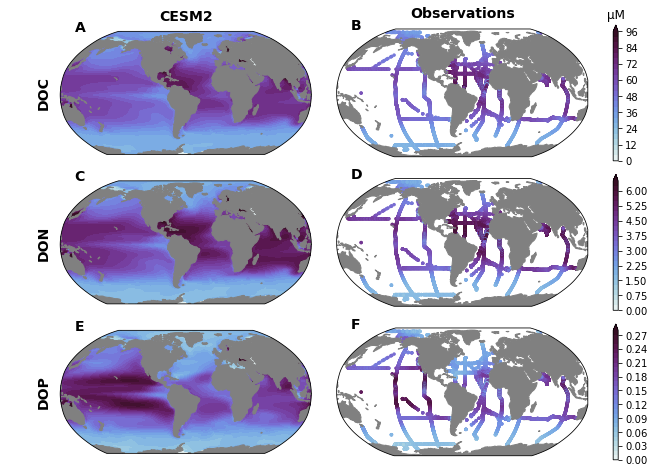

In [10]:
fields = ['DOCt', 'DONt', 'DOPt']

levels = {field: plot.nice_levels(df[field]) for field in fields}


fig = plt.figure(figsize=(10, 8))
prj = ccrs.Robinson(central_longitude=305.0)

nrow, ncol = len(fields), 2 
gs = gridspec.GridSpec(
    nrows=nrow, ncols=ncol+1, 
    width_ratios=(1, 1, 0.02),
    wspace=0.15, 
    hspace=0.1,
)

axs = np.empty((nrow, ncol)).astype(object)
caxs= np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):    
    axs[i, j] = plt.subplot(gs[i, j], projection=prj)
    caxs[i, j] = plt.subplot(gs[i, -1])

cmap_field = cmocean.cm.dense

depth_range = (0., 100.)

for i, field in enumerate(fields):    
    for j in range(2):
        ax = axs[i, j]
        
        if j == 0:
            zslice = slice(depth_range[0]*100., depth_range[1]*100.)
            cf = ax.contourf(
                dsp.TLONG,dsp.TLAT, dsp[field].sel(z_t=zslice).mean('z_t'),
                levels=levels[field],
                extend='max',
                cmap=cmap_field,
                norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
                transform=ccrs.PlateCarree(),
            )
        else:
            df_sub = df.loc[(depth_range[0] <= df.depth) & (df.depth <= depth_range[1])]
            sc = ax.scatter(
                df_sub.lon, df_sub.lat, c=df_sub[field].values,
                cmap=cmap_field,
                norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
                s=6,
                transform=ccrs.PlateCarree(),)
            
        land = ax.add_feature(
            cartopy.feature.NaturalEarthFeature(
                'physical','land','110m',
                edgecolor='face',
                facecolor='gray'
            )
        )  

    cb = plt.colorbar(cf, cax=caxs[i, j])        
    if 'units' in dsp[field].attrs and i == 0:
        cb.ax.set_title(dsp[field].attrs['units'])
    
utils.subplot_col_labels(axs[0, :], ['CESM2', 'Observations'])    
utils.subplot_row_labels(axs[:, 0], [f.replace('t', '') for f in fields], xoff=60)

utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=0.02, yoff=0)    
         
utils.savefig('DOM-concentration-maps.pdf')

In [11]:
dsp.info()

xarray.Dataset {
dimensions:
	lat_aux_grid = 395 ;
	moc_z = 61 ;
	nlat = 384 ;
	nlon = 321 ;
	z_t = 60 ;
	z_t_150m = 15 ;
	z_w = 60 ;
	z_w_bot = 60 ;
	z_w_top = 60 ;

variables:
	float32 z_t(z_t) ;
		z_t:long_name = depth from surface to midpoint of layer ;
		z_t:units = centimeters ;
		z_t:positive = down ;
		z_t:valid_min = 500.0 ;
		z_t:valid_max = 537500.0 ;
	float64 TLAT(nlat, nlon) ;
	float64 TLONG(nlat, nlon) ;
	float64 DOC(z_t, nlat, nlon) ;
		DOC:long_name = Dissolved Organic Carbon ;
		DOC:units = µM ;
		DOC:grid_loc = 3111 ;
		DOC:cell_methods = time: mean ;
	float64 HTE(nlat, nlon) ;
		HTE:long_name = cell widths on East sides of T cell ;
		HTE:units = centimeters ;
	float64 DXT(nlat, nlon) ;
		DXT:long_name = x-spacing centered at T points ;
		DXT:units = centimeters ;
	float64 T0_Kelvin() ;
		T0_Kelvin:long_name = Zero Point for Celsius ;
		T0_Kelvin:units = degK ;
	float64 salt_to_ppt() ;
		salt_to_ppt:long_name = Convert Salt in gram/gram to g/kg ;
	float64 heat_to_PW()

In [12]:
for flavor in ['', 't', 'r']:
    doc_to_don = ds[f'DOC{flavor}'].isel(z_t=0) / ds[f'DON{flavor}'].isel(z_t=0)
    don_to_dop = ds[f'DON{flavor}'].isel(z_t=0) / ds[f'DOP{flavor}'].isel(z_t=0)

    C = (((doc_to_don * don_to_dop) * masked_area).sum(['nlat', 'nlon']) / masked_area.sum(['nlat', 'nlon'])).values
    N2P = ((don_to_dop * masked_area).sum(['nlat', 'nlon']) / masked_area.sum(['nlat', 'nlon'])).values
    if not flavor:
        print('semilabile:', end=' ')
    elif flavor == 't':
        print('total:', end=' ')        
    elif flavor == 'r':
        print('refractory:', end=' ')        
        
    print(f'{C[0]:0.0f}:{N2P[0]:0.0f}:{1}')

semilabile: 238:21:1
total: 365:26:1
refractory: 968:52:1


In [28]:
df_sub = df.loc[df.depth <= 100.]
for flavor in ['t_obs', 't']:
    doc_to_don = df_sub[f'DOC{flavor}'] / df_sub[f'DON{flavor}'].where(df_sub[f'DON{flavor}']>0.)
    don_to_dop = df_sub[f'DON{flavor}'] / df_sub[f'DOP{flavor}'].where(df_sub[f'DOP{flavor}']>0.)
    C = (doc_to_don * don_to_dop).mean()
    N2P = (don_to_dop).mean()
    
    if flavor == 't':
        print('total (model):', end=' ')        
    elif flavor == 't_obs':
        print('total (obs):', end=' ')                
    print(f'{C:0.0f}:{N2P:0.0f}:{1}')

total (obs): 735:60:1
total (model): 385:29:1
